In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [4]:
df = pd.read_csv("./combine_2010_2025")


In [5]:
df = df[df["Pos"].isin(["WR", "CB", "RB", "FS", "OLB", "ILB", "SS", "TE"])]

In [6]:

data = df[["Vertical", "Ht", "40yd"]]
data = data.dropna()
scaler = StandardScaler()


In [7]:
X, y = data.drop(["40yd"], axis="columns"), data["40yd"]
X_train, X_test, y_train, y_test = train_test_split(scaler.fit_transform(X), y, test_size=0.2)

In [8]:
models = {}

In [9]:



rf = GridSearchCV(RandomForestRegressor(), {
    "n_estimators": [1, 10, 50, 100, 200, 500],
    "max_depth": [2, 3, 4, 5, 7, 10, None],
})

rf.fit(X_train, y_train)
models["RandomForestRegressor"] = rf

In [10]:
et = GridSearchCV(ExtraTreesRegressor(), {
    "n_estimators": [10, 50, 100, 200, 500],    
    "max_depth": [2, 3, 4, 5, 7, 10, None],
})

et.fit(X_train, y_train)
models["ExtraTreesRegressor"] = et

In [11]:
xgb = GridSearchCV(XGBRegressor(), {
    "n_estimators": [10, 50, 100, 200, 500],
    "max_depth": [2, 3, 4, 5, 7, 10, None],
})

xgb.fit(X_train, y_train)
models["XGBRegressor"] = xgb

In [12]:
xrf = GridSearchCV(XGBRFRegressor(), {
    "n_estimators": [10, 50, 100, 200, 500],
    "max_depth": [2, 3, 4, 5, 7, 10, None]
})

xrf.fit(X_train, y_train)
models["XGBRFRegressor"] = xrf

In [13]:




mlp = GridSearchCV(MLPRegressor(), {
    ""
    "max_iter": [10000],
    "solver": ["lbfgs", "adam"],
    "hidden_layer_sizes": [(100, 50, 20), (200, 100, 40), (500, 200, 100, 50), (600, 500, 200, 100, 50), (500, 400, 300, 210, 160, 120, 80, 50)]
})

mlp.fit(X_train, y_train)
models["MLPRegressor"] = mlp


In [14]:
from sklearn.metrics import mean_squared_error
var = X_test.var()

for key, model in models.items():
    mse = mean_squared_error(y_test, model.predict(X_test))
    r_score = 1 - mse / var
    print(key.ljust(30) + str(r_score))

RandomForestRegressor         0.985237199424399
ExtraTreesRegressor           0.9856406591514364
XGBRegressor                  0.9854248364613768
XGBRFRegressor                0.9853832294027595
MLPRegressor                  0.9856322064073958


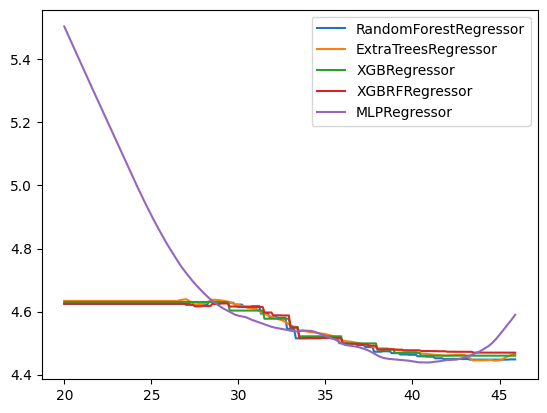

In [48]:

vertical = list(np.arange(20, 46, 0.1))
my_data = pd.DataFrame({
    "Vertical": vertical,
    "Ht": [70] * len(vertical),
})
my_data = scaler.transform(my_data)

for key, model in models.items():
    prediction = model.predict(my_data)
    plt.plot(vertical, prediction, label=key)

plt.legend()
plt.show()

In [ ]:
my_data

c:\Users\Krzysztof\Documents\IT_Projects\athlete-analysis\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Krzysztof\Documents\IT_Projects\athlete-analysis\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Krzysztof\Documents\IT_Projects\athlete-analysis\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Krzysztof\Documents\IT_Projects\athlete-analysis\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Krzysztof\Documents\IT_Projects\athlete-analysis\.venv\Lib\site

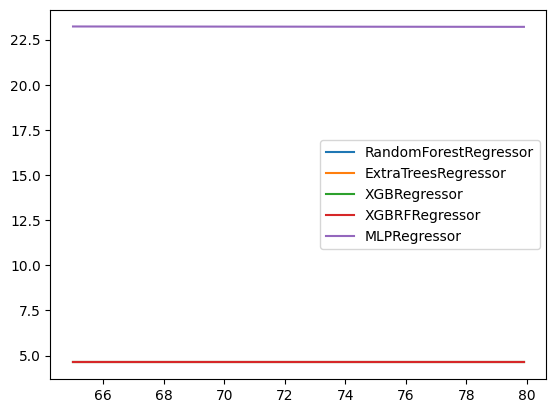

In [ ]:
model = mlp
ht = list(np.arange(65, 80, 0.1))
my_data = pd.DataFrame({
    "Vertical": [35] * len(ht),
    "Ht": ht,
})
my_data = scaler.transform(my_data)
for key, model in models.items():
    prediction = model.predict(my_data)
    plt.plot(ht, prediction, label=key)

plt.legend()
plt.show()

In [17]:
import pickle

with open("models.pickle", "wb") as file:
    pickle.dump(models, file)

In [47]:
d = pd.DataFrame({
    "Vertical": [35],
    "Ht": [80]
})

d = scaler.transform(d)

models["MLPRegressor"].predict(d)

array([4.84869598])